<a href="https://colab.research.google.com/github/benihime91/oxford-iiit-pet-PyTorch/blob/master/nb_007_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting-up ...

In [ ]:
! tar zxvf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/

In [2]:
! pip install --upgrade albumentations

     |████████████████████████████████| 122kB 4.6MB/s 
     |████████████████████████████████| 952kB 14.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=56f0c4529957a81cc8e2917ed6babeb9042d675f1a31eac593b202dc56fc72fc
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Preprocess Data:
- Grab the `image paths` and `labels`.
- Verify all the `images`.
- Create a `dataframe` from the `image paths` and `labels`.
- Convert all `labels` to integers.
- Shuffle the `dataframe`.
- Create Stratified `K-Folds`.
- Save the `train_set` and the `validation_sets`.

In [1]:
import pandas as pd
import os
import shutil
import re
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn import preprocessing, model_selection
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None, "display.max_row", None)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Extract the images and labels and create a `DataFrame`

In [2]:
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

In [3]:
desc = Path("/content/oxford-iiit-pet/images")
ims = list(desc.iterdir())
im_list = []

for im in ims:
    if str(im).split(os.path.sep)[-1].split(".")[-1] == "jpg": im_list.append(str(im))
im_list[:5], len(im_list)

(['/content/oxford-iiit-pet/images/saint_bernard_168.jpg',
  '/content/oxford-iiit-pet/images/great_pyrenees_147.jpg',
  '/content/oxford-iiit-pet/images/Bengal_109.jpg',
  '/content/oxford-iiit-pet/images/Birman_104.jpg',
  '/content/oxford-iiit-pet/images/leonberger_28.jpg'],
 7390)

- **Check for corrupted images**

In [21]:
for im in tqdm(im_list):
    try: _ = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
    except:
        im_list.remove(im)
        print(f"[INFO] Corrupted Image: {im}")

[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Egyptian_Mau_145.jpg
[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Egyptian_Mau_139.jpg
[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Egyptian_Mau_191.jpg
[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Egyptian_Mau_167.jpg
[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Egyptian_Mau_177.jpg
[INFO] Corrupted Image: /content/oxford-iiit-pet/images/Abyssinian_34.jpg



In [22]:
df = pd.DataFrame()
df["fnames"] = im_list
df["labels"] = [ pat.search(fname).group(1).lower() for fname in df.fnames]
df["targets"] = preprocessing.LabelEncoder().fit_transform(df.labels.values)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,fnames,labels,targets
0,/content/oxford-iiit-pet/images/keeshond_180.jpg,keeshond,18
1,/content/oxford-iiit-pet/images/basset_hound_120.jpg,basset_hound,3
2,/content/oxford-iiit-pet/images/British_Shorthair_116.jpg,british_shorthair,9
3,/content/oxford-iiit-pet/images/shiba_inu_210.jpg,shiba_inu,31
4,/content/oxford-iiit-pet/images/great_pyrenees_113.jpg,great_pyrenees,15


- **Create `StratifiedKFolds`**

In [23]:
df["kfold"] = -1

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y = df.labels.values

for n, (_, valid_idx) in enumerate(skf.split(X=df, y=y)):
    df.loc[valid_idx, "kfold"] = n

df.head()

,fnames,labels,targets,kfold
0,/content/oxford-iiit-pet/images/keeshond_180.jpg,keeshond,18,2
1,/content/oxford-iiit-pet/images/basset_hound_120.jpg,basset_hound,3,4
2,/content/oxford-iiit-pet/images/British_Shorthair_116.jpg,british_shorthair,9,4
3,/content/oxford-iiit-pet/images/shiba_inu_210.jpg,shiba_inu,31,3
4,/content/oxford-iiit-pet/images/great_pyrenees_113.jpg,great_pyrenees,15,2


- **Save the `DataFrame(s)`**

In [9]:
df_trn = df.loc[df.kfold != 0]
df.to_csv("train_df.csv", index=False)
df_trn.head()

,fnames,labels,targets,kfold
0,/content/oxford-iiit-pet/images/staffordshire_bull_terrier_46.jpg,staffordshire_bull_terrier,34,3
2,/content/oxford-iiit-pet/images/Maine_Coon_169.jpg,maine_coon,20,2
3,/content/oxford-iiit-pet/images/Egyptian_Mau_25.jpg,egyptian_mau,11,3
4,/content/oxford-iiit-pet/images/British_Shorthair_51.jpg,british_shorthair,9,1
5,/content/oxford-iiit-pet/images/staffordshire_bull_terrier_76.jpg,staffordshire_bull_terrier,34,1


In [10]:
for num in [0, 1, 2, 3, 4]:
    df_val = df.loc[df.kfold == num]
    df.to_csv(f"val_df_{num}.csv", index=False)

In [11]:
# Checkout the number of samples in the train and validation datasets
print("Num training examples: ", len(df_trn))
print("Num validation examples: ", len(df_val))

Num training examples:  5907
Num validation examples:  1476


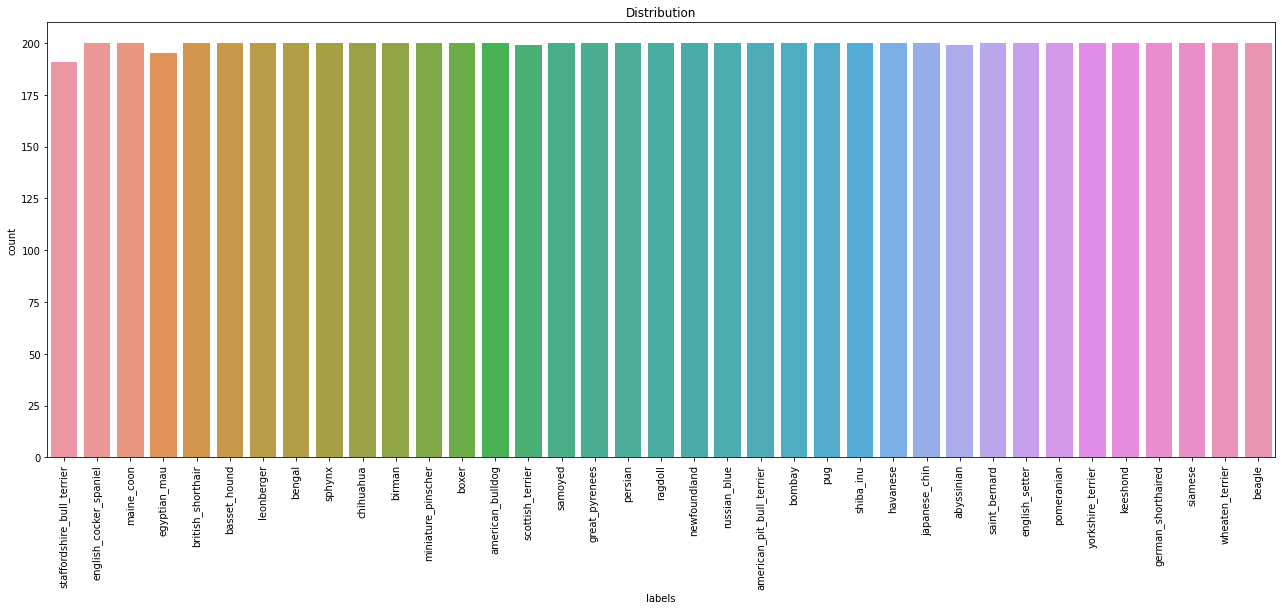

In [14]:
_, ax = plt.subplots(1, 1, figsize=(22, 8))
sns.countplot(x=df.labels, ax=ax)
ax.set_title("Distribution")
plt.xticks(rotation=90);

## Create `torch.utils.Dataset` instance and  `torch.utils.data.DataLoader` instance

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [5]:
h = 224 #@param{type:"integer"}
w = 224 #@param{type:"integer"}

In [6]:
def transforms(trn:bool=False):
    if trn: 
        tfms = [A.CLAHE(), A.IAAPerspective(), A.IAASharpen(), A.RandomBrightness(),
                A.Rotate(limit=60), A.HorizontalFlip()]
    else: tfms = []
    tfms.append(A.Resize(h,w, always_apply=True))
    tfms.append(A.Normalize(always_apply=True))
    tfms.append(ToTensorV2(always_apply=True))
    tfs = A.Compose(tfms)
    return tfs

In [7]:
class ParseData(Dataset):
    def __init__(self, pth, tfms_fn):
        self.df = pd.read_csv(pth)
        self.tfms = tfms_fn
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        try: pth = self.df.fnames[idx]
        except Exception: print(idx)
        im = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
        im = self.tfms(image=im)["image"]
        lbl = self.df.targets[idx]
        return im, lbl

In [81]:
trn_dl = DataLoader(ParseData("/content/train_df.csv", transforms(True)),batch_size=128,shuffle=True, pin_memory=True)

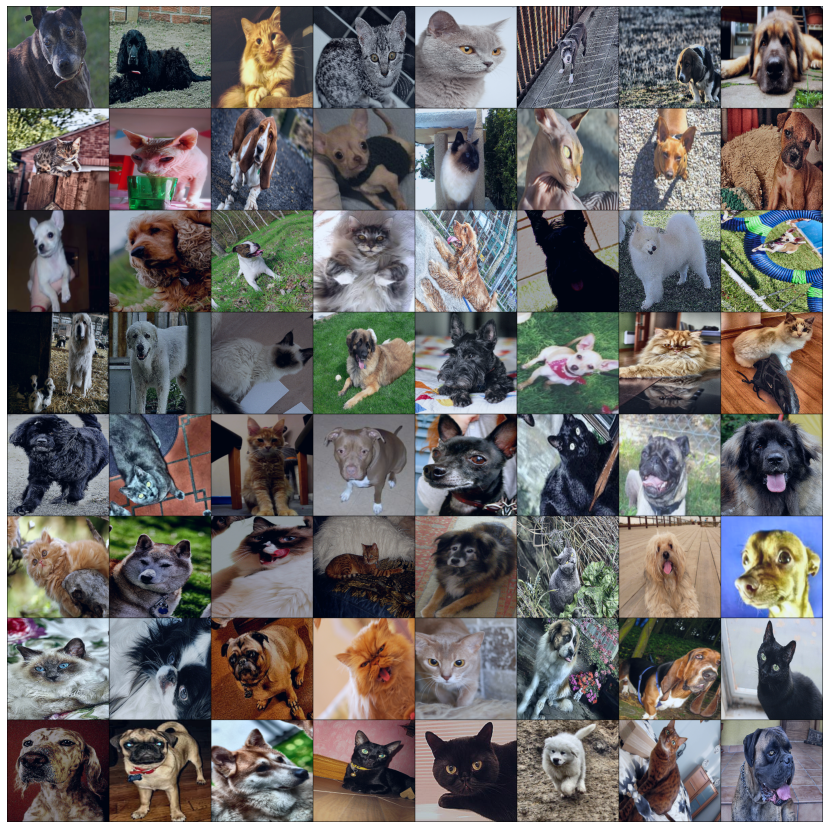

In [20]:
# Extract and plot 1 batch for sanity-check
batch = next(iter(trn_dl))

im, _ = batch
grid = make_grid(im[:64], normalize=True, padding=True).permute(1, 2, 0)

_, ax = plt.subplots(1, 1, figsize=(22, 15))
ax.imshow(grid.numpy())
ax.set_axis_off()

- Grab the validation `DataLoader(s)`

In [8]:
val_dl_0 = DataLoader(ParseData("/content/val_df_0.csv", transforms(False)), batch_size=128, pin_memory=True)
val_dl_1 = DataLoader(ParseData("/content/val_df_1.csv", transforms(False)), batch_size=128, pin_memory=True)
val_dl_2 = DataLoader(ParseData("/content/val_df_2.csv", transforms(False)), batch_size=128, pin_memory=True)
val_dl_3 = DataLoader(ParseData("/content/val_df_3.csv", transforms(False)), batch_size=128, pin_memory=True)
val_dl_4 = DataLoader(ParseData("/content/val_df_4.csv", transforms(False)), batch_size=128, pin_memory=True)

# Creat a list to store all the validation dataloaders
val_loaders = [val_dl_0, val_dl_1, val_dl_2, val_dl_3, val_dl_4]

In [9]:
val_loaders

## Create Training Helper Functions :
- Create `fn` to calculate validation `metrics`.
- Create `fn` for `training step`.
- Create `fn` for `validation step`.
- Create `fn` for `Training Loop`.
- Create a `class` to track `training & valiation` stats.
- Create an `Engine` class to `Train & Evaluate` the model.

In [33]:
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn import metrics
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def save_model(model, best_loss, loss, path):
    """Saves model whenever validation loss decreases"""
    if loss < best_loss:
        torch.save(model.state_dict(), path)
    return loss

In [12]:
# Create a Recorder Class:
# This class will recorder the `trn_loss`, `val_loss` , `learning_rate`, `momentum` and
# additionally plot the `losses` , `learning_rates` and `momentum`
class Recorder():
    def __init__(self):
        self.losses = []
        self.val_losses = []
        self.lrs = []
        self.moms = []
    def update_loss(self, trn_loss, val_loss):
        self.losses.append(trn_loss), self.val_losses.append(val_loss)
    def update_lrs_moms(self, lrs, moms):
        self.lrs.append(lrs)
        self.moms.append(moms)
    def reset_states(self):
        self.losses = []
        self.val_losses = []
        self.lrs = []
        self.moms = []
    def plot_losses(self):
        plt.figure(figsize=(8,8))
        plt.plot(self.losses, label="training_loss", color="salmon")
        plt.plot(self.val_losses, label="validation loss", color="teal")
        plt.legend()
        plt.title("Training/Validation Loss");
        plt.ylabel("Loss")
        plt.xlabel("# Epochs")
    def plot_lrs(self):
        plt.figure(figsize=(8,8))
        plt.plot(self.lrs, color="salmon")
        plt.title("Learning rate");
        plt.ylabel("Learning rate")
        plt.xlabel("# Steps")
    def plot_moms(self):
        plt.figure(figsize=(8,8))
        plt.plot(self.moms, color="salmon")
        plt.title("Momentum");
        plt.ylabel("Momentum")
        plt.xlabel("# Steps")

In [13]:
def calc_mt(logits, yb):
    _, preds = torch.max(logits, 1)
    # calculate accuracy
    acc = metrics.accuracy_score(yb.cpu().numpy(), preds.cpu().numpy())
    # calculate the error_rate
    error_rate = (1 - acc)/(yb.cpu().numpy().shape[0])
    return acc, error_rate

In [14]:
def trn_step(model, trn_loader, optimizer, criterion, scheduler, recorder, mb):
    model.train()
    loss = 0.
    optimizer.zero_grad()
    for j, (xb,yb) in enumerate(progress_bar(trn_loader, parent=mb)):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss_value = criterion(logits, yb)
        loss += loss_value
        mb.child.comment = f"batch_loss: {loss_value.item():.3f}"
        # update weights
        loss_value.backward()
        torch.nn.utils.clip_grad_value_([p for p in model.parameters() if p.requires_grad], 0.1)
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        # update recorder
        try: recorder.update_lrs_moms(optimizer.param_groups[0]["lr"], optimizer.param_groups[0]["momentum"])
        except: recorder.update_lrs_moms(optimizer.param_groups[0]["lr"], 0)
    # average loss
    loss /= len(trn_loader)
    return loss

In [15]:
def val_step(model, val_loader, criterion, mb):
    loss, acc, error_rate = 0., 0., 0.
    model.eval()
    for n, (xb, yb) in enumerate(progress_bar(val_loader, parent=mb)):
        with torch.no_grad():
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss += criterion(logits, yb).item()
            acc_n, error_rate_n = calc_mt(logits, yb)
            acc += acc_n
            error_rate += error_rate_n
    # Average Statistics
    loss /= len(val_loader)
    acc /= len(val_loader)
    error_rate /= len(val_loader)
    return loss, acc, error_rate

In [37]:
TEMPLATE = "Epoch {} - train loss: {:.3f}  val loss: {:.3f}  accuracy: {:.3f}%  error_rate: {:.4f}"

class Engine:
    def __init__(self):
        self.recorder = Recorder()

    def fit_one_cycle(self, model, dataloaders, optim, criterion, epochs, max_lr, pth=None):
        model.to(device)
        trn_dl, val_dl = dataloaders["train"], dataloaders["valid"]
        best_loss = np.Inf
        schd = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trn_dl), epochs=epochs)
        mb = master_bar(range(epochs))
        for n in mb:
            trn_loss = trn_step(model, trn_dl, optim, criterion, schd, self.recorder, mb)
            val_loss, val_acc, error_rate = val_step(model, val_dl, criterion, mb)
            self.recorder.update_loss(trn_loss, val_loss)
            if pth is not None: best_loss = save_model(model, best_loss, val_loss, pth)
            mb.write(TEMPLATE.format(n+1, trn_loss, val_loss, val_acc*100., error_rate))
        if pth is not None: model.load_state_dict(torch.load(pth))
    
    @staticmethod
    def evaluate(model, dl, criterion):
        model.to(device)
        loss, acc, error_rate = val_step(model, dl, criterion, mb=None)
        return loss, acc, error_rate  # Return loss and accuracy

## Instantiate Model
- Load a `pretrained` model.
- Add a `classifier`.
- create a `nn.Module` instance & add `fns` to `freeze` and `unfreeze` model.

In [17]:
from torchvision import models
from torchsummary import summary
from torch import nn
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self, base, classifier):
        super(Net, self).__init__()
        self.base = base
        self.clf = classifier
    def forward(self, xb):
        return self.clf(self.base(xb))
    def freeze(self):
        for params in self.base.parameters():
            params.requires_grad = False
    def unfreeze(self):
        for params in self.base.parameters():
            params.requires_grad = True

In [19]:
base_m = models.resnet34(pretrained=True)

In [24]:
f1 = base_m.fc.out_features
f2 = len(df.targets.unique())

clf_m = nn.Sequential(
    nn.BatchNorm1d(f1),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(f1, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, f2))

In [25]:
model = Net(base_m, clf_m)
model

Net(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

## Train Model

In [36]:
! pip install torch_lr_finder

In [39]:
from torch_lr_finder import LRFinder
engine = Engine()

### Train only the `classifier` i.e., `Freeze` the model

In [97]:
model.freeze()

# Check summary
summary(model.to(device), input_size=(3, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
prms = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(prms, lr=1e-07, momentum=0.9, weight_decay=1e-02)
criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


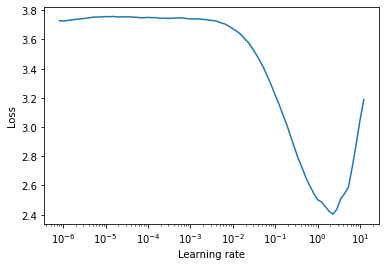

In [99]:
lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(trn_dl, end_lr=100)
lr_finder.plot()
lr_finder.reset()

#### **`fit_one_cycle`**

> **Stage-01**

In [100]:
EPOCHS = 8
max_lr = 8e-02
pth = "/content/checkpoints/stage-01"
loaders = {"train":trn_dl, "valid":val_dl_0}

engine.fit_one_cycle(model, loaders, optimizer, criterion, EPOCHS, max_lr=max_lr, pth=pth)

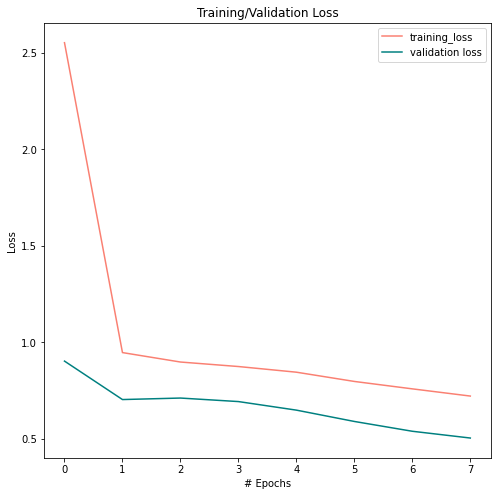

In [103]:
engine.recorder.plot_losses()

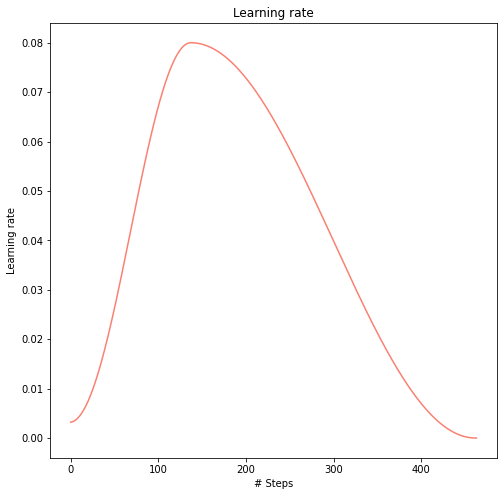

In [104]:
engine.recorder.plot_lrs()

### Train only whole `model` i.e., `unfreeze` the `model`.

In [105]:
model.unfreeze()

# Check summary
summary(model.to(device), input_size=(3, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [106]:
prms = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(prms, lr=1e-07, momentum=0.9, weight_decay=1e-02)
criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


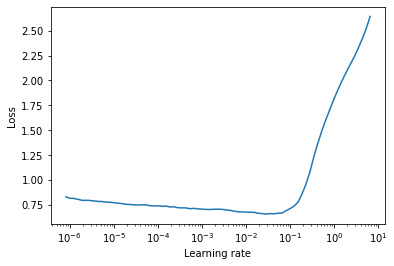

In [107]:
lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(trn_dl, end_lr=100)
lr_finder.plot()
lr_finder.reset()

In [110]:
torch.cuda.empty_cache()

#### **`fit_one_cycle`**

> **Stage-02**

`Discriminative` learning rates.

In [117]:
EPOCHS = 5
max_lr = 7e-03
optimizer = torch.optim.SGD([{'params': model.base.parameters(), "lr": max_lr/5},
                             {'params': model.clf.parameters(), 'lr': max_lr}], 
                            momentum=0.9, weight_decay=1e-02)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0014
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01

Parameter Group 1
    dampening: 0
    lr: 0.007
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
)

In [118]:
pth = "/content/checkpoints/stage-02"
loaders = {"train":trn_dl, "valid":val_dl_0}

engine.fit_one_cycle(model, loaders, optimizer, criterion, EPOCHS, max_lr=max_lr, pth=pth)

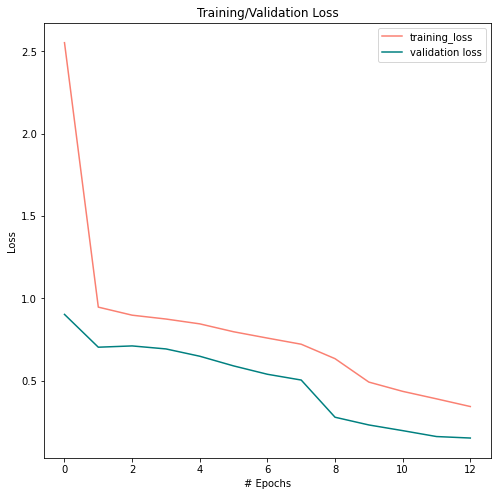

In [123]:
engine.recorder.plot_losses()

In [121]:
torch.save(model.state_dict(), "pets_model")

In [122]:
torch.save(model, "pets_model.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Check `Cross-Validation` stats

In [26]:
# Load in the best Model
model.load_state_dict(torch.load("/content/pets_model"))

<All keys matched successfully>

In [28]:
from IPython import display

In [48]:
losses = []
ers = []
accs = []
# Iterate over the cross-validation dataloaders
for n, loader in enumerate(tqdm(val_loaders, leave=False)):
    print(f"\n[INFO] Evaluating Fold: {n+1}")
    loss, acc, er = engine.evaluate(model, loader, criterion)
    print(f"[INFO] Fold {n+1} - loss: {loss:.4f} accuracy: {acc:.4f} error_rate: {er:.4f}")
    losses.append(loss)
    accs.append(acc)
    ers.append(er)
display.clear_output()

In [49]:
print(f"CV loss: {np.mean(losses):.4f}")
print(f"CV accuracy: {np.mean(accs) * 100:.4f}%")
print(f"CV error_rate: {np.mean(ers):.4f}")

CV loss: 0.1521
CV accuracy: 97.7591%
CV error_rate: 0.0002
